<a href="https://colab.research.google.com/github/andvar95/Inteligencia-Artificial/blob/main/NLP_GenerateText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#librerias

In [ ]:
import tensorflow as tf
import numpy as np 
import os 
import time
from tensorflow.keras.layers.experimental import preprocessing

Downliading Shakespeare dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

Looking the text

In [ ]:
#Read, then decode for py2 compat.
text = open(path_to_file,'rb').read().decode(encoding='UTF-8')
#length of text the numbrs of characers in it
print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [ ]:
#The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))


65 unique characters


#Process Text-Vectorize text

Before training, you need convert the strings to a numerical representation

preprocessing.StringLoopkup layer can convert each char in a numeric ID. It just needs the text to be split into token first.

In [ ]:
idx_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab)
)

char_from_idx = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=idx_from_chars.get_vocabulary(),invert=True
)

#Prediction Task

Given a characters or a sequence of them, what's the most probable next character? 

The input will be a sequence of characters, and you train to predict the output-the following characters at each time step

RNN maintain an internal state that depends on previously seen elements, given all characters computed until this moment, what's the next?

#Creating training Example and target

Next divide the text sequence. Each input will contain seq_length charters from the text.

The corresponding targts contain the same length of text, except shifted one character to the right 

In the text "Hello"

Input -> "Hell"
Output -> "ello"

To do this first use **tf.data.Dataset.from_tensor_slices** function to convert the text vector into a stream of character indices

In [ ]:
all_idx = idx_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_idx

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([20, 49, 58, ..., 47, 10,  2])>

In [ ]:
idx_dataset = tf.data.Dataset.from_tensor_slices(all_idx)

In [ ]:
for idx in idx_dataset.take(10):
  print(char_from_idx(idx).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
samples_per_epoch = len(text)//(seq_length+1)

The **batch** method lets you convert these individual characters to sequences of the desired size

In [ ]:
sequences = idx_dataset.batch(seq_length+1,drop_remainder=True)

for seq in sequences.take(1):
  print(char_from_idx(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
def text_from_idx(idx):
  return tf.strings.reduce_join(char_from_idx(idx),axis=-1)

for seq in sequences.take(5):
  print(text_from_idx(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Now, we will create the function to generate train and label

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text,target_text

split_input_target(list('Tensorflow'))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input,target in dataset.take(1):
  print("Input :",text_from_idx(input).numpy())
  print("Target:",text_from_idx(target).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#Create training batches

Before feeding the data into model, it's needed to shuffle the data and pack it into batches

In [ ]:
#Batch Size

BATCH_SIZE = 64

#Buffer size to shuffle the dataet
#TF data is designed to work with infite sequennces
#It doesn't attempt to shuffle the entire sequences in memory
#It maintains a buffer in wich it shuffle elements

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

#Build the Model

This section defines the models as a keras.mode sub class 

This model has three layers:

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map each char-ID to a vector with embedding_dim dimensiones

tf.keras.layers.GRU: A type of RNN size units = rnn_units (You can also use a LSTM)

tf.keras.layers.Dense: The output, with vocab_size outputs. It outputs one logit for each char in vocabulary. These re the log-liklihood of each characters accoeding to the model. 

In [ ]:
#length of the vocabulary in chars
vocab_size = len(vocab)


#The embedding dimensiones
embedding_dim = 256

#Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,rnn_units):
    super().__init__(self)
    self.embedding= tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)
  def call(self,inputs,states=None,return_state=False,training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state = states,training=training)
    x = self.dense(x,training=training)
    if return_state:
      return x,states
    else:
      return x

In [ ]:
model = MyModel(
    
    vocab_size = len(idx_from_chars.get_vocabulary()),
    embedding_dim = embedding_dim,rnn_units= rnn_units)

For each character the model looks up the embebdding, runs de the GRU with embedding as input, and applies the debse layer to generate logits predicting the log-likelihood of the next character

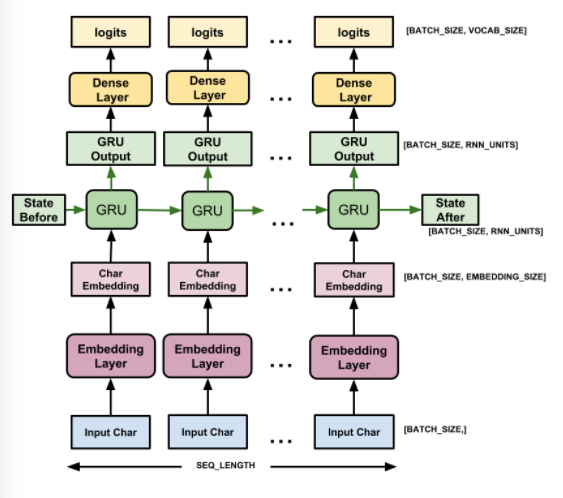


#Try the model

Now run the model to see that it behaves as expect

First check the shape of the output

In [ ]:
for input_example_batch,target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size")

(64, 100, 67) # (batch_size, sequence_length, vocab_size


In the above example the sequences length of input es 100 but the model can be run on inputs of any length

In [ ]:
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  17152     
_________________________________________________________________
gru_3 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_3 (Dense)              multiple                  68675     
Total params: 4,024,131
Trainable params: 4,024,131
Non-trainable params: 0
_________________________________________________________________


To get teh actual precitions from the model you need to sample from output destribution, to get the actual indices. The distribution es defined by the logits over the character vocabulary

First example in the batch

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1)

In [ ]:
sampled_indices

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([15,  9, 20,  3, 42, 19, 29, 11, 28,  1, 30, 28, 64, 56, 13, 27, 27,
       40, 48,  0,  1, 55, 18, 37, 14, 53, 42, 35, 21, 25,  0, 41, 57, 64,
       65, 35, 21, 44, 38,  7, 60, 24, 49, 42, 47, 30, 57, 33,  0, 18,  0,
       55, 18, 48, 63, 13, 62, 61, 61, 38, 16, 66, 41,  3, 47, 25, 50, 58,
       44, 59, 55, 29, 50, 65, 36,  7, 52, 35,  2, 16, 22, 46,  1, 11,  9,
       15, 11, 53, 34, 54, 24,  8, 47, 36, 27, 47, 16, 32, 48, 32])>

Decode these to see the text predicted by hus untrained model

In [ ]:
print("Input:\n",text_from_idx(input_example_batch[0]).numpy())
print("Output:\n",text_from_idx(sampled_indices).numpy())

Input:
 b'hich is yours.\n\nYORK:\nMine boy? not till King Henry be dead.\n\nRICHARD:\nYour right depends not on his'
Output:
 b"A-F bEO3N[UNK]PNxp;MMZh[UNK]oDW?mbUGKaqxyUGdX'tJibgPqSDoDhw;vuuXBza gKjrdsoOjyV'lU\nBHf[UNK]3-A3mTnJ,gVMgBRhR"


#Train Model

At this point the problem  can be treated as a treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

#Attach an optimizer, and a loss function

The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case because it is applied across the last dimension of the predictions 

Because your model return logits, you need to set the from_logits flag. 

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_loss = loss(target_example_batch,example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape)
print("Mean loss: ",mean_loss)

Prediction shape:  (64, 100, 67)
Mean loss:  4.204318


A newly initialized odel shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponenetial of the meain loss is approximately equal to the vocabulary size. A much higher loss mean the model is sure of its wrong ansers, and is badly initialized

In [ ]:
tf.exp(mean_loss).numpy()

66.97491

In [ ]:
model.compile(optimizer='adam',loss=loss)

In [ ]:
#Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

#Name of the checkpoints files
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt_{epoch}")

checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_prefix,
    save_weights_only = True
)

In [ ]:
history  = model.fit(dataset, epochs=20, callbacks=[checkpoint_callbacks])

Epoch 1/20
172/172 [==============================] - 882s 5s/step - loss: 3.3406
Epoch 2/20
172/172 [==============================] - 886s 5s/step - loss: 2.0930
Epoch 3/20
172/172 [==============================] - 888s 5s/step - loss: 1.7782
Epoch 4/20
172/172 [==============================] - 886s 5s/step - loss: 1.5833
Epoch 5/20
172/172 [==============================] - 882s 5s/step - loss: 1.4723
Epoch 6/20
172/172 [==============================] - 893s 5s/step - loss: 1.3925
Epoch 7/20
172/172 [==============================] - 889s 5s/step - loss: 1.3350
Epoch 8/20
172/172 [==============================] - 882s 5s/step - loss: 1.2882
Epoch 9/20
172/172 [==============================] - 875s 5s/step - loss: 1.2413
Epoch 10/20
172/172 [==============================] - 873s 5s/step - loss: 1.1989
Epoch 11/20
172/172 [==============================] - 877s 5s/step - loss: 1.1586
Epoch 12/20
172/172 [==============================] - 879s 5s/step - loss: 1.1141
Epoch 13/20
1

#Generate the Text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it 

Each time you cal the model you pass in some text and and internal state. The model returns a prediction for the next character and its new state.Pass the prediction and state back  in to continue generating text 

The following makes a single step prediction





In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self,model,chars_from_idx,idx_from_chards,temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_idx = chars_from_idx
    self.idx_from_chars =  idx_from_chars

    #create a mask to prevent " " or "[UNK]" from being generated
    skip_ids = self.idx_from_chars(['','[UNK]'])[:,None]
    sparse_mask = tf.SparseTensor(
        #Put a -inf at each bad index
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        dense_shape=[len(idx_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)
  @tf.function
  def generate_one_step(self,inputs,states=None):
    #convert string to toekn IDS
    input_chars = tf.strings.unicode_split(inputs,'UTF-8')
    input_ids = self.idx_from_chars(input_chars).to_tensor()
    
    #RUN THE MODEL 
    #Predicted_logits.shape is [batch,char,next_char_logits]
    predicted_logits , states = self.model(inputs=input_ids,states=states,
                                            return_state=True)

    #Only use the last prediction
    predicted_logits = predicted_logits[:,-1,:]
    predicted_logits = predicted_logits/self.temperature

    #Apply the prediction mask: prevent "" or "[UNK]" from being generated
    predicted_logits = predicted_logits + self.prediction_mask

    #sample the output logits to generate token IDS
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    #converto from token ids to character
    predicted_chards = self.chars_from_idx(predicted_ids)

    #Return the character and model state
    return predicted_chards, states

In [ ]:
one_step_model = OneStep(model,char_from_idx,idx_from_chars)

Run it in a loop to generate some text. Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writting vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):

  next_char, states = one_step_model.generate_one_step(next_char,states= states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'),'\n\n'+'_'*80)
print(f"\nRun time: {end-start}")

ROMEO:
Pardon me, good friend Lucio, till the priest and true Pisas with
mine actors word, if any place which is great profane.

Second Murderer:
So force you, good merry, that's last.

ISABELLA:
Who told me, and if you love no gold? I thought
I do then here are written that there next.

BENVOLIO:
It will ture forth to constract them! Vouchsaff, take that I
say, poor wroting, come. What's their own children!
Thou didst love farewell up rot of warrant.
What, would the jest of this steel guilty my life?

GLOUCESTER:
And, by a man-keet my mother, thou,
March'd, way if thine own great person all is sequent,
Because is past out to be given thee,
For now is fear'd, and half you look on all,
That skin I was a bastard.
Thy father laid were to a silence on the issue
Of conduction of my throne,
Will hund me with the chair can man that all have edopted
He made a father's height to me.

BUCKINGHAM:
Even to the Volsces shall purchaste with me
The blackery of my brother widow sister?

KATHARY NORTH:

The easiest thing you can do to improve the results is to train it lor longer (30 EPOCHS)

You can also experiment with a different start string, try adding another RNN Layer to improve the model's accuracy, or adjust the temperature parameter to generate more or less random predictions

If you want the model to generate text *faster* the easiest thing you can do is batch text generation. In the example below the model can generates 5 outputs in about the same time it took to generate 1 above

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO: ','ROMEO:','ROMEO:','ROMEO:','ROMEO:'])
result = [next_char]
for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char,states=states)
  result.append(next_char)
result = tf.strings.join(result)
end = time.time()

print(result,'\n\n '+ '_'*80)

print(f"\nRun time:{end-start}")

tf.Tensor(
[b"ROMEO: Grance, fool!--\nFor not of ear too late?\n\nSICINIUS:\nStay, let's all sworn to\nHomonies to be a lady's face.\nGood gentlemen, woman, whom we do calm them?\nIs there no remedy! How often hast\nshe was my father's cere? O chquir'd mother,\nWe commune with a perly occadate as bear\nRomeo to be quick.\n\nMENENIUS:\nHang these and goodness of his polect\nlors, as puralm thee, but by the way\nto play at home with the slaughter,\nOne relect, there cannot guess whose wrong.\n\nKING RICHARD II:\nThat all already.\n\nBAPTISTA:\nI must be well under these airs.\n\nAUTOLYCUS:\nHa, ha' now, no kingdom Lord; whwere he old prevost,\nAs rest the rest o' the yokence with the sacrament\nto this be o'er.\n\nPOMPEY:\nPray no monet, bold, your advice; you will be pleased\nFor baiting with these forces of\nYour days and patricians ignorance, which does,\nClervolk, altogied toward tempest sound thus;\nwhother at him of honour and obey?\n\nWARWICK:\nSeizize him; hell hast! Sow I will p

#Export the generator

This single-step model can easily be saved and restored allowing you to use anywhere a tf.saved_model is accpeted

In [ ]:
tf.saved_model.save(one_step_model,'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [ ]:
states = None
next_char = tf.constant(['ROMEO: '])
result = [next_char]

for i in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char,states=states)
  result.append(next_char)
print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO: I am undone's woe:
loave well-faced imonously to France:
And hast the corse of Bianca
Lost lovely be


#Advanced: Customized Training

The above training procedure is simple, but does not give you much control. It uses teacher-forcing which prevents bad predictions from being fed back to the model so the model never learns to recover from mistakes

So now that you've seen how to run the model manually next you'll implement the trainings loop. This gives s starting point if, for example, you want implement curriculum learning to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use tf.GradientTape to track the gradients. You can learn more about this approach by reading the eager execution guide

The basic procedure is:
1. Execute the model and calculate  the loss under a tf.GradientTape
2.Calculate the updates and apply them to the model using optimizer 

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self,inputs):
    inputs,labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs,training=True)
      loss = self.loss(labels,predictions)
    grads = tape.gradient(loss,model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads,model.trainable_variables))

    return {'loss':loss}

The above implementation of the train_step method follows Keras' train_step conventions.  This is optional, but it allows you to change the behavior of the train step and still use keras' Model.compile and Model.fit methods


In [ ]:
model = CustomTraining(
    vocab_size = len(idx_from_chars.get_vocabulary()),
    embedding_dim= embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              )

In [ ]:
model.fit(dataset,epochs=1)

172/172 [==============================] - 844s 5s/step - loss: 2.6874


Or if you need more control, you can write your own complete custom training loop

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()
  mean.reset_states()

  for (batch_n,(inp,target)) in enumerate(dataset):
    logs = model.train_step([inp,target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = 'Epoch {} Batch {} Loss{}'
      print(template.format(epoch+1,batch_n,logs['loss']))
  #saving (checkpoint) the model every 5 epochs

  if ( epoch +1) % 5 ==0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))
  print()
  print('Epoch {} Loss:{:.4f}'.format(epoch+1,mean.result().numpy()))
  print('Time taken for 1 epoch {} sec'.format(time.time()-start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))


Epoch 1 Batch 0 Loss2.1745564937591553
Epoch 1 Batch 50 Loss2.002150058746338
Epoch 1 Batch 100 Loss1.9347532987594604
Epoch 1 Batch 150 Loss1.8432519435882568

Epoch 1 Loss:1.9672
Time taken for 1 epoch 840.7125413417816 sec
Epoch 2 Batch 0 Loss1.793877363204956
Epoch 2 Batch 50 Loss1.7236452102661133
Epoch 2 Batch 100 Loss1.6522111892700195
Epoch 2 Batch 150 Loss1.6672186851501465

Epoch 2 Loss:1.6908
Time taken for 1 epoch 843.1421854496002 sec
Epoch 3 Batch 0 Loss1.5464941263198853
Epoch 3 Batch 50 Loss1.5813069343566895
Epoch 3 Batch 100 Loss1.5540143251419067
Epoch 3 Batch 150 Loss1.4707956314086914

Epoch 3 Loss:1.5337
Time taken for 1 epoch 840.4143326282501 sec
Epoch 4 Batch 0 Loss1.4395211935043335
Epoch 4 Batch 50 Loss1.4646159410476685
Epoch 4 Batch 100 Loss1.467626929283142
Epoch 4 Batch 150 Loss1.4083011150360107

Epoch 4 Loss:1.4376
Time taken for 1 epoch 840.7282977104187 sec
Epoch 5 Batch 0 Loss1.3748538494110107
Epoch 5 Batch 50 Loss1.3727253675460815
Epoch 5 Batch 10

NameError: ignored